In [148]:
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
from sklearn.preprocessing import StandardScaler

In [149]:
data = pd.read_csv('./processed_data/train.csv')
data.head()

,tpep_pickup_datetime,passenger_count,trip_distance,DOLocationID,fare_amount,tip_amount,total_amount,pickup_count,weekday,is_holiday
0,2022-01-24 00:00:00,13.0,49.14,1583,173.00,19.25,237.35,12,False,False
1,2022-01-24 00:30:00,9.0,51.99,1524,174.43,31.24,245.92,9,False,False
2,2022-01-24 01:00:00,12.0,37.72,1242,137.50,19.86,209.51,12,False,False
3,2022-01-24 01:30:00,7.0,11.99,785,50.50,13.09,86.39,6,False,False
4,2022-01-24 02:00:00,7.0,15.40,998,64.50,7.65,94.95,6,False,False


In [150]:
data['tpep_pickup_datetime'] = pd.to_datetime(data['tpep_pickup_datetime'])
data = data.set_index('tpep_pickup_datetime')

data['row'] = range(1, len(data) + 1)
data['tpep_pickup_datetime'] = data.index
data.head()
data = data[:100]

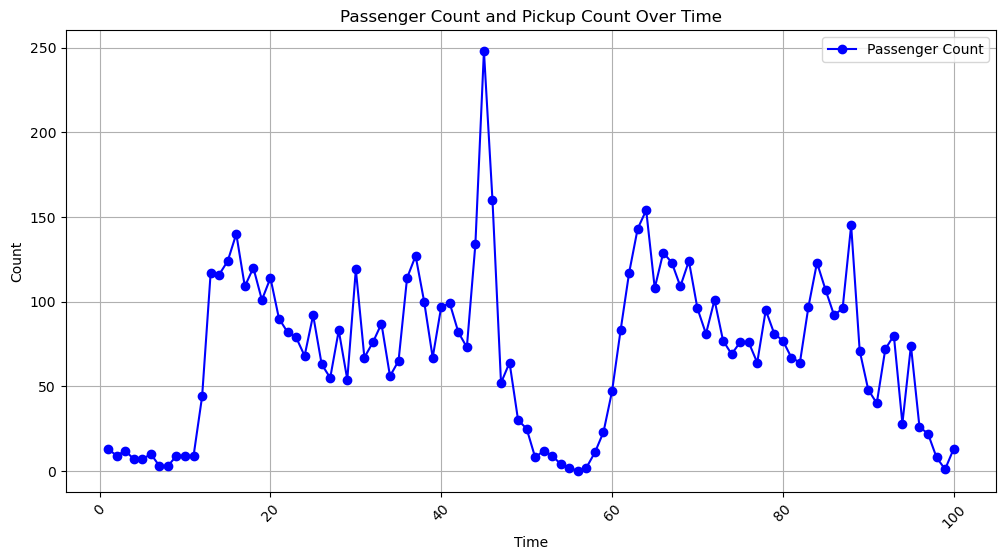

In [151]:
plt.figure(figsize=(12, 6))
plt.plot(data['row'], data['passenger_count'], marker='o', label='Passenger Count', color='blue')
plt.title('Passenger Count and Pickup Count Over Time')
plt.xlabel('Time')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.show()

In [152]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 100 entries, 2022-01-24 00:00:00 to 2022-01-26 01:30:00
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   passenger_count       100 non-null    float64       
 1   trip_distance         100 non-null    float64       
 2   DOLocationID          100 non-null    int64         
 3   fare_amount           100 non-null    float64       
 4   tip_amount            100 non-null    float64       
 5   total_amount          100 non-null    float64       
 6   pickup_count          100 non-null    int64         
 7   weekday               100 non-null    bool          
 8   is_holiday            100 non-null    bool          
 9   row                   100 non-null    int64         
 10  tpep_pickup_datetime  100 non-null    datetime64[ns]
dtypes: bool(2), datetime64[ns](1), float64(5), int64(3)
memory usage: 8.0 KB


In [153]:
# weekday, is_holiday, pickup_count (Xt), tip amount

In [154]:
# Features (X) - All columns except 'pickup_count'
X = data[['tip_amount', 'weekday', 'is_holiday']].values

# Target (y) - 'pickup_count'
y = data['pickup_count'].values

# Scale features if necessary (important for GP models to avoid dominance of larger scale features)
#scaler = StandardScaler()
#X_scaled = scaler.fit_transform(X)

#print(X_scaled)

In [155]:
# Define the kernel: A product of a constant kernel (C) and RBF kernel (Radial Basis Function)
kernel = C(1.0, (1e-4, 1e1)) * RBF(1.0, (1e-4, 1e1))

# Instantiate the GaussianProcessRegressor with the kernel
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=10, alpha=1e-2)

# Fit the GP model to the data
gp.fit(X, y)
print("Fit")

# Make predictions on the input data
y_pred, sigma = gp.predict(X, return_std=True)
print("Predicted")

Fit
Predicted


/Users/willcalandra/anaconda3/envs/tsa/lib/python3.12/site-packages/sklearn/gaussian_process/kernels.py:452: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__constant_value is close to the specified upper bound 10.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


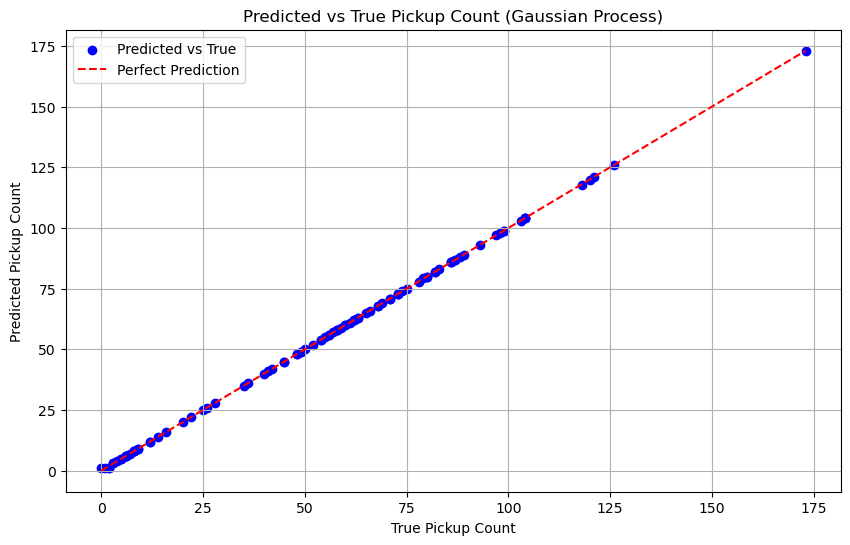

In [156]:
import matplotlib.pyplot as plt

# Prediction vs True Values plot
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred, color='blue', label='Predicted vs True')
plt.plot([min(y), max(y)], [min(y), max(y)], color='red', linestyle='--', label='Perfect Prediction')
plt.xlabel('True Pickup Count')
plt.ylabel('Predicted Pickup Count')
plt.title('Predicted vs True Pickup Count (Gaussian Process)')
plt.legend()
plt.grid(True)
plt.show()

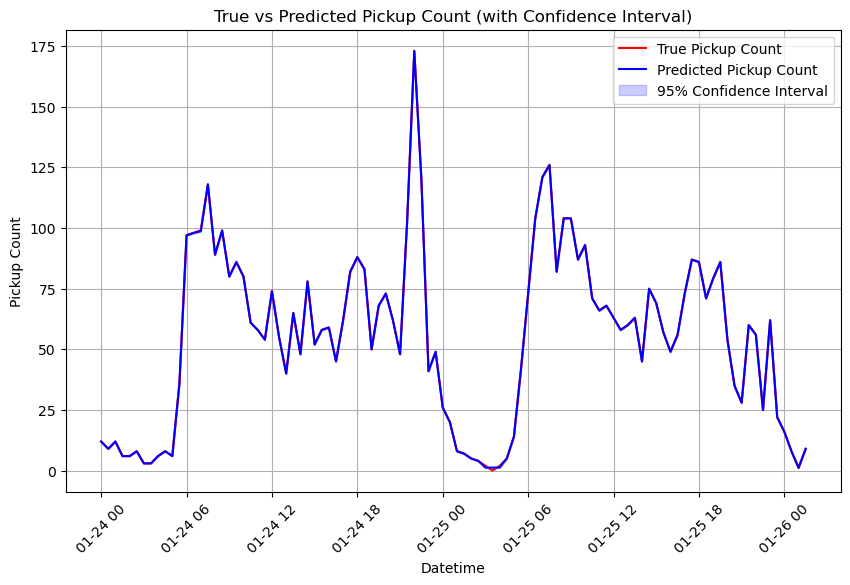

In [157]:
plt.figure(figsize=(10, 6))
plt.plot(data['tpep_pickup_datetime'], y, label='True Pickup Count', color='red')
plt.plot(data['tpep_pickup_datetime'], y_pred, label='Predicted Pickup Count', color='blue')
plt.fill_between(data['tpep_pickup_datetime'], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Datetime')
plt.ylabel('Pickup Count')
plt.title('True vs Predicted Pickup Count (with Confidence Interval)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()


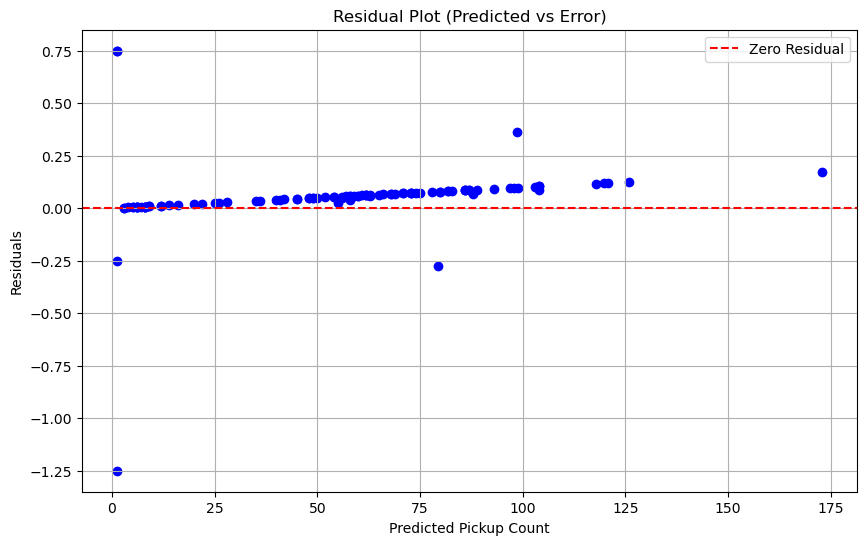

In [158]:
# Compute residuals
residuals = y - y_pred

# Residual plot
plt.figure(figsize=(10, 6))
plt.scatter(y_pred, residuals, color='blue')
plt.axhline(0, color='red', linestyle='--', label='Zero Residual')
plt.xlabel('Predicted Pickup Count')
plt.ylabel('Residuals')
plt.title('Residual Plot (Predicted vs Error)')
plt.legend()
plt.grid(True)
plt.show()


In [159]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

# RMSE
rmse = np.sqrt(mean_squared_error(y, y_pred))
print("RMSE:", rmse)

# R²
r2 = r2_score(y, y_pred)
print("R²:", r2)


RMSE: 0.18330961316071018
R²: 0.9999737724788034


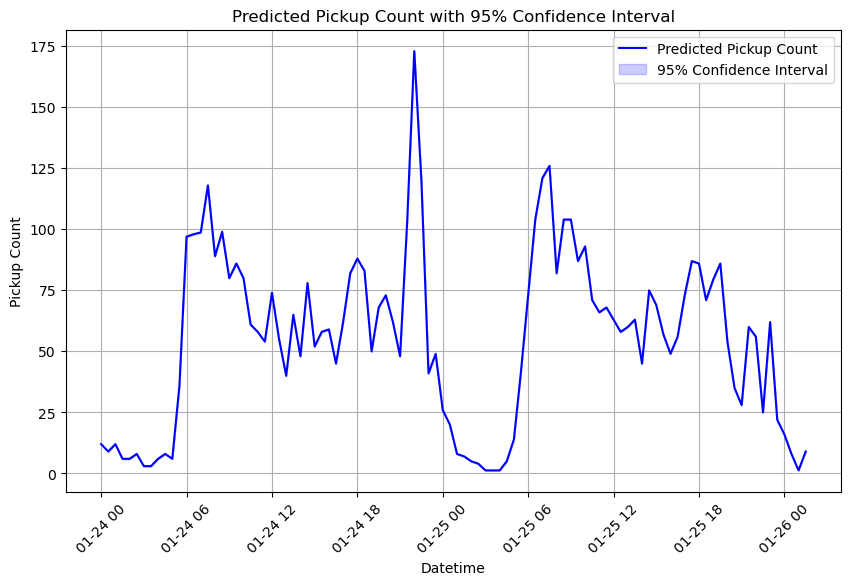

In [160]:
plt.figure(figsize=(10, 6))
plt.plot(data['tpep_pickup_datetime'], y_pred, label='Predicted Pickup Count', color='blue')
plt.fill_between(data['tpep_pickup_datetime'], y_pred - 1.96 * sigma, y_pred + 1.96 * sigma, color='blue', alpha=0.2, label='95% Confidence Interval')
plt.xlabel('Datetime')
plt.ylabel('Pickup Count')
plt.title('Predicted Pickup Count with 95% Confidence Interval')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
